# **Load the Dataset**

In [1]:
train_dir="/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train"
test_dir ="/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test"
batch_size=64
img_height=128
img_width=128

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import pandas as pd
import numpy as np
import os
from tensorflow.keras.utils import load_img,img_to_array
from collections import Counter
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

2025-08-11 08:06:01.089359: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754899561.380416      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754899561.466091      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory( #load train dataset
  train_dir,
  validation_split=0.2,
  subset="training",
  shuffle=True,
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)#//

#split validation dataset from train dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size
)#//


#Based on the filename inside the test data, we need to load images manually one-by-one, then match labels based on the filename
file_names=[]
image_list=[]
label_list=[]

for file in os.listdir(test_dir): #get all filenames in the folder
  if file.endswith('.jpg'):
    file_names.append(file)
for f in file_names:
  label=f.split("_")[0]
  img_path=os.path.join(test_dir, f)#load the image with target size
  img=load_img(img_path,target_size=(img_height,img_width))
  img_array=img_to_array(img) #convert to array and normalize
  image_list.append(img_array)# add to image_list
  label_list.append(label)# add to label_list

X_test=np.array(image_list)#//
y_test=label_list#//

Found 87000 files belonging to 29 classes.
Using 69600 files for training.


2025-08-11 08:07:16.993143: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Found 87000 files belonging to 29 classes.
Using 17400 files for validation.


# **Exploratory Data Analysis**

The goal is to explore and improve training data quality and balance before training your model.

In [4]:
train_class_names=train_ds.class_names
print(train_class_names)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


N: 3000 images
R: 3000 images
space: 3000 images
B: 3000 images
I: 3000 images
del: 3000 images
F: 3000 images
H: 3000 images
E: 3000 images
U: 3000 images
M: 3000 images
X: 3000 images
K: 3000 images
Q: 3000 images
Y: 3000 images
S: 3000 images
G: 3000 images
A: 3000 images
O: 3000 images
T: 3000 images
V: 3000 images
Z: 3000 images
C: 3000 images
P: 3000 images
L: 3000 images
W: 3000 images
D: 3000 images
nothing: 3000 images
J: 3000 images


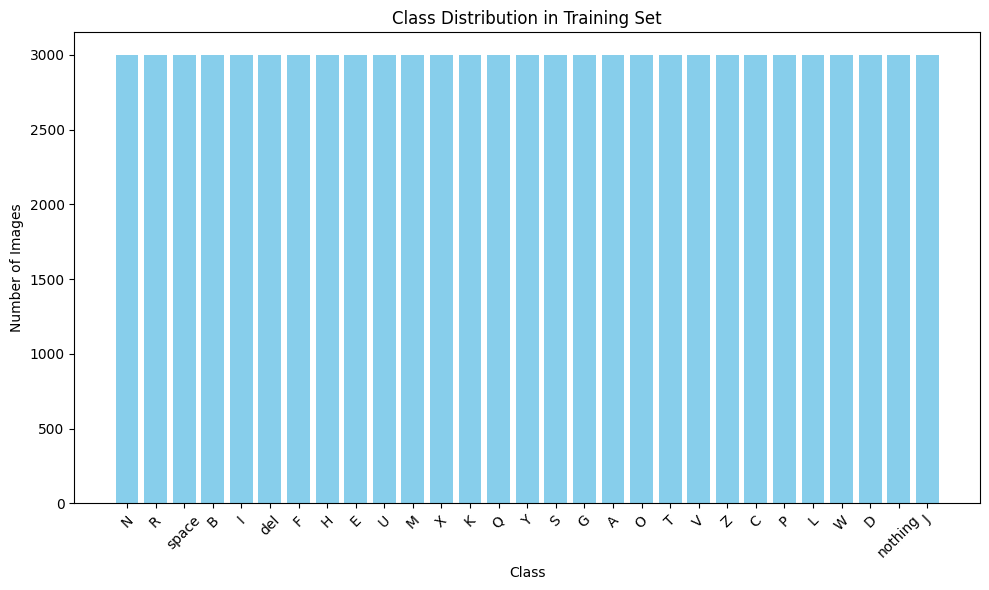

In [5]:
class_counts = Counter()

for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        num_images = len([
            f for f in os.listdir(class_path)
            if f.endswith(".jpg") or f.endswith(".png")
        ])
        class_counts[class_name] = num_images

#display class distribution
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")

classes=list(class_counts.keys())
counts=list(class_counts.values())

plt.figure(figsize=(10,6))
plt.bar(classes, counts, color='skyblue')
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Class Distribution in Training Set")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Then, we will visualize sample images from train dataset

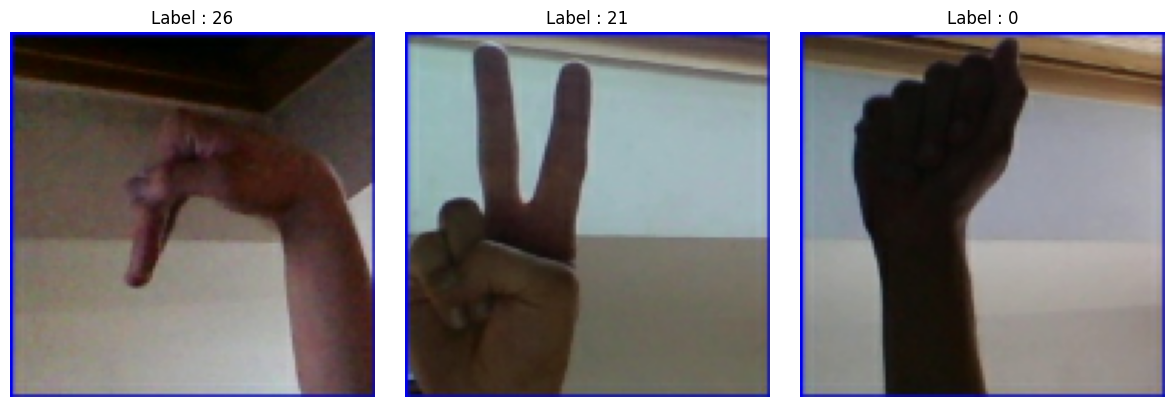

In [6]:
sampled_images=[]
sampled_labels=[]

for images,labels in train_ds.take(1):
  sampled_images = images.numpy()
  sampled_labels=labels.numpy()

#random choosing 3 images from the batch
random_indices=np.random.choice(len(sampled_images),3, replace=False)

plt.figure(figsize=(12,4))
for i,idx in enumerate(random_indices):
  plt.subplot(1,3,i+1)
  plt.imshow(sampled_images[idx].astype("uint8"))
  plt.title(f"Label : {sampled_labels[idx]}")
  plt.axis("off")
plt.tight_layout()
plt.show()

# **Model Architecture**

In [7]:
model=tf.keras.models.Sequential([
    tf.keras.Input(shape=(128,128,3)),
    tf.keras.layers.Rescaling(scale=1./255),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(256,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(29,activation='softmax')
])

In [8]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 29)             │         1,885 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 431,453 (1.65 MB)

 Trainable params: 431,453 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

# **Model Training**

In [ ]:
checkpoint_cb = ModelCheckpoint('/kaggle/working/best_asl_model.h5',save_best_only=True,monitor='val_accuracy',mode='max',verbose=1)

In [ ]:
history = model.fit(train_ds,validation_data=val_ds,epochs=20,callbacks=[checkpoint_cb])

<!! The model was successfully trained during a previous session. However, due to a kernal synchronization issue, the output history from that issue was lost. To proceed, the pre-trained model has been loaded, and further analysis or inference continues from this point. !!>

In [10]:
model = load_model('/kaggle/input/asl-classifier/keras/default/1/best_asl_model.h5')

In [11]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
history = model.fit(train_ds,validation_data=val_ds,epochs=20,initial_epoch=12, callbacks=[checkpoint_cb])

# **Plotting the training and validation loss and accuracy**

In [ ]:
loss=history.history["loss"]
val_loss=history.history["val_loss"]
epochs=range(1, len(loss) +1)
plt.plot(epochs,loss,"bo",label="Training loss")
plt.plot(epochs,val_loss,"b",label="Validation loss")
plt.title('Training and Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs_range=range(1, len(acc)+1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# **Evaluation**

In [12]:
val_loss, val_acc = model.evaluate(val_ds)
print(val_acc)

272/272 ━━━━━━━━━━━━━━━━━━━━ 104s 378ms/step - accuracy: 0.9987 - loss: 0.0038
0.9987931251525879


Now, the test data will be passed to the model for evaluation.

In [13]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Map string labels in y_test to integer indices 
label_to_index = {label: idx for idx, label in enumerate(train_class_names) if label != 'del'}
y_test_indices = np.array([label_to_index[label] for label in y_test])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


In [14]:
print(classification_report(y_test_indices, y_pred, target_names=[label for label in train_class_names if label != 'del']))

              precision    recall  f1-score   support

           A       1.00      1.00      1.00         1
           B       1.00      1.00      1.00         1
           C       1.00      1.00      1.00         1
           D       1.00      1.00      1.00         1
           E       1.00      1.00      1.00         1
           F       1.00      1.00      1.00         1
           G       1.00      1.00      1.00         1
           H       1.00      1.00      1.00         1
           I       1.00      1.00      1.00         1
           J       1.00      1.00      1.00         1
           K       1.00      1.00      1.00         1
           L       1.00      1.00      1.00         1
           M       1.00      1.00      1.00         1
           N       1.00      1.00      1.00         1
           O       1.00      1.00      1.00         1
           P       1.00      1.00      1.00         1
           Q       1.00      1.00      1.00         1
           R       1.00    

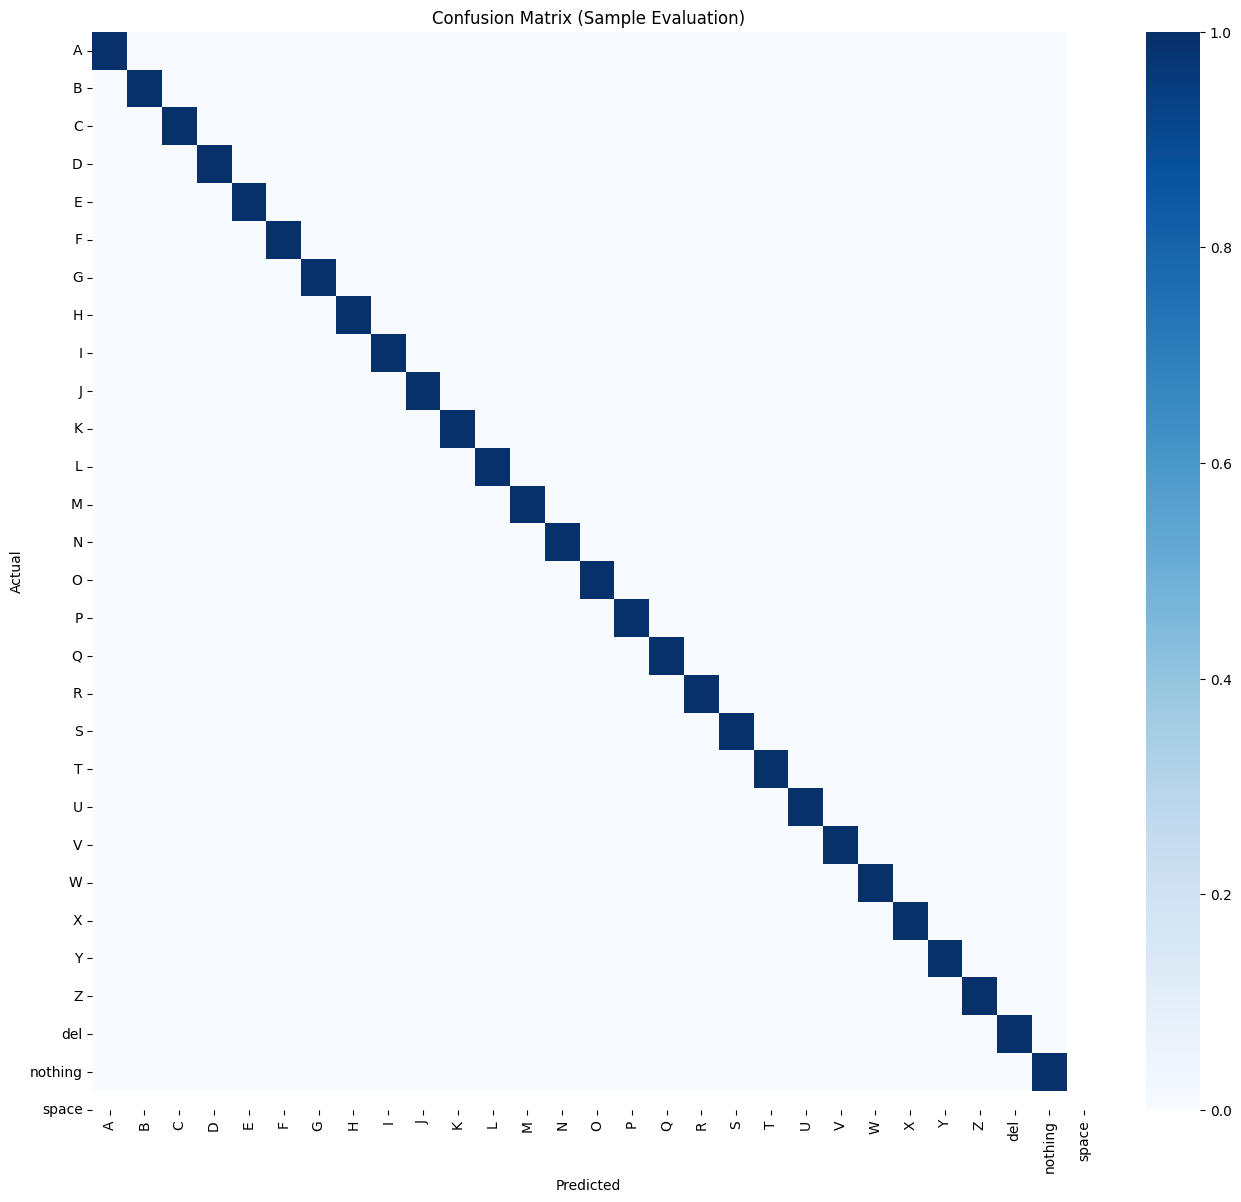

In [15]:
cm = confusion_matrix(y_test_indices, y_pred)
plt.figure(figsize=(16, 14))
sns.heatmap(cm, annot=False, fmt='d',
            xticklabels=train_ds.class_names,
            yticklabels=train_ds.class_names,
            cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Sample Evaluation)')
plt.show()

In [16]:
for img, label in zip(X_test, y_test):
    pred_label = train_class_names[np.argmax(model.predict(np.expand_dims(img, axis=0)))]
    print(f"True: {label}, Predicted: {pred_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
True: A, Predicted: A
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
True: E, Predicted: E
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
True: L, Predicted: L
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
True: N, Predicted: N
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
True: S, Predicted: S
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
True: D, Predicted: D
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
True: G, Predicted: G
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
True: I, Predicted: I
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
True: W, Predicted: W
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
True: M, Predicted: M
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
True: nothing, Predicted: nothing
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
True: X, Predicted: X
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
True: H, Predicted: H
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
True: Q, Predicted: Q
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
True: C, Predicted: C
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
True: T, Predicted: T
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

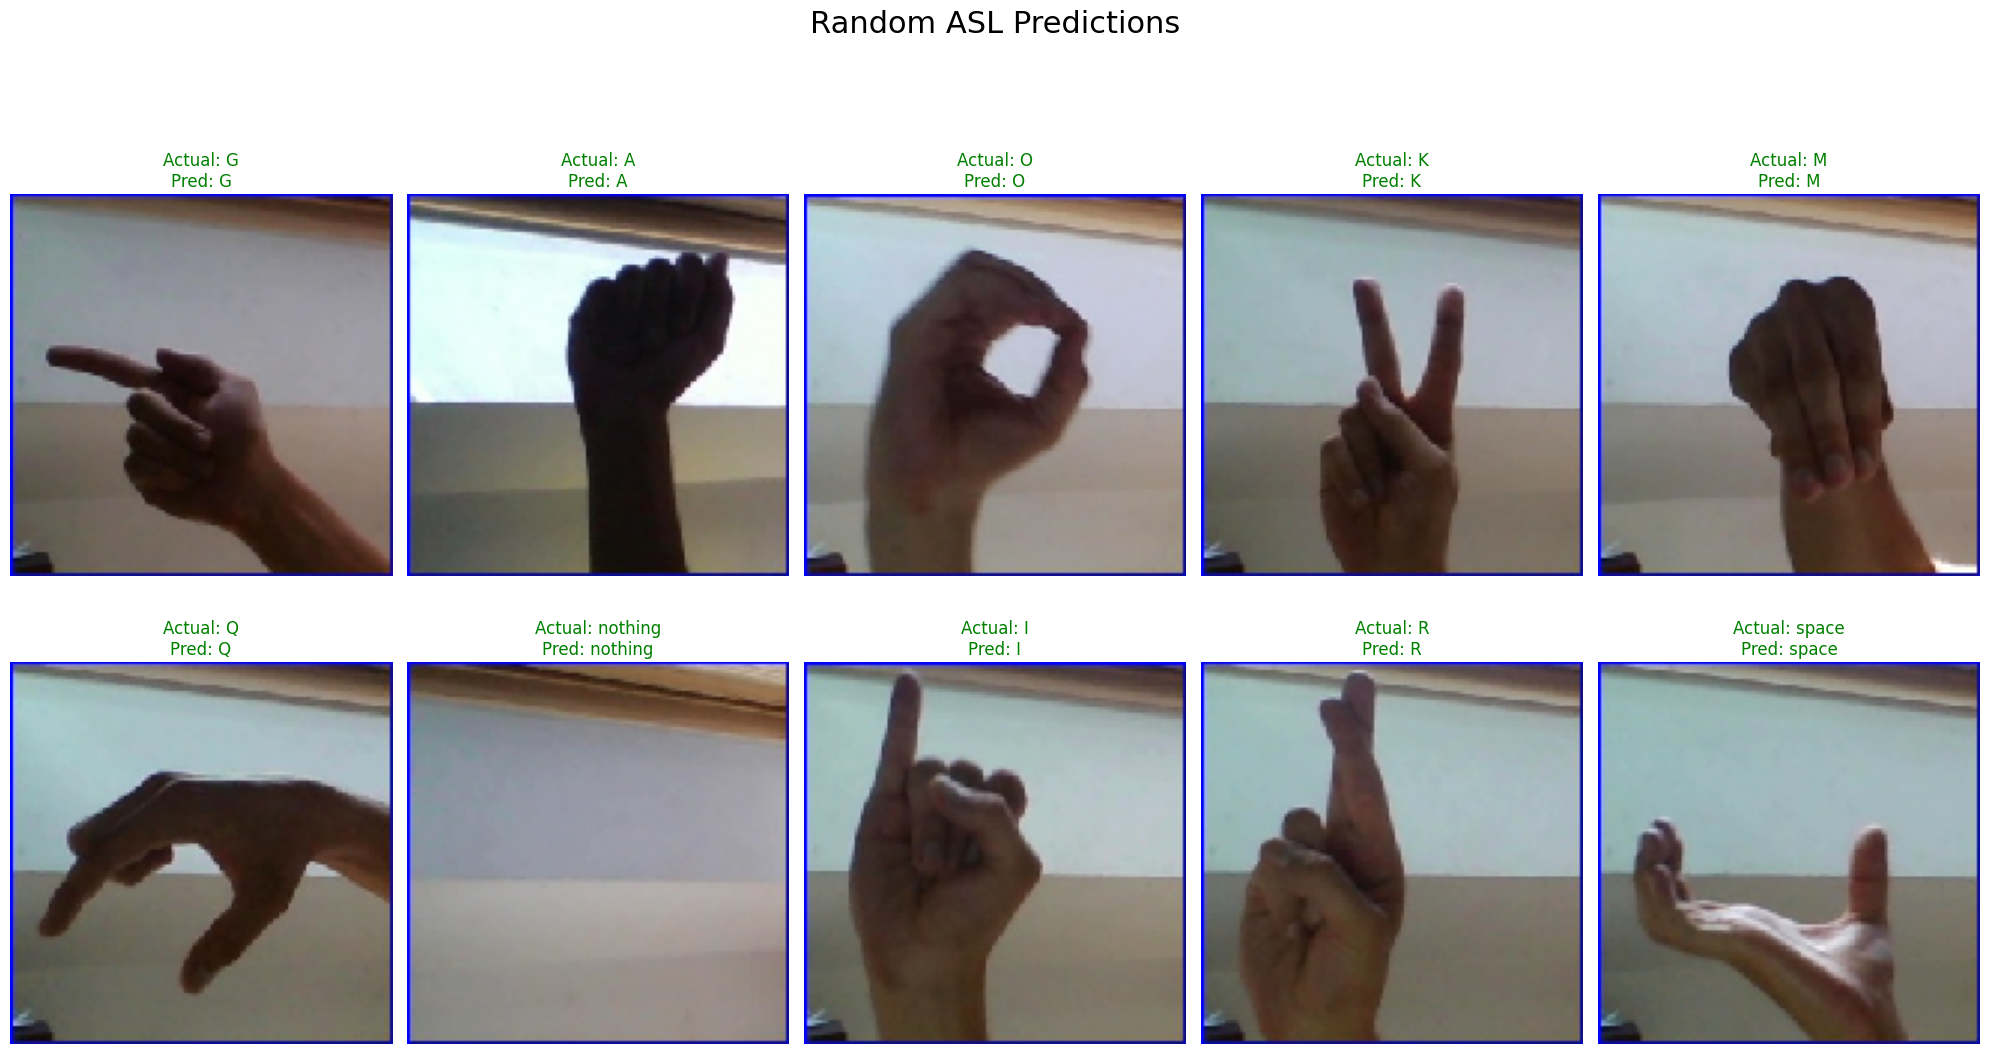

In [17]:
def visualize_predictions(images, true_labels, pred_labels, class_names, num_samples=10):
    plt.figure(figsize=(20, 12))

    #pick random sample indices
    sample_indices = np.random.choice(len(images), size=num_samples, replace=False)

    for i, idx in enumerate(sample_indices):
        img = images[idx]
        if hasattr(img, "numpy"):  
            img = img.numpy()

        if np.issubdtype(img.dtype, np.floating):
            mx = float(img.max())
            if mx > 1.5:  # float in 0-255 range
                img = np.clip(img, 0, 255).astype(np.uint8)
            else:  # float in 0-1 range
                img = (np.clip(img, 0, 1) * 255).astype(np.uint8)
        elif img.dtype != np.uint8:
            img = np.clip(img, 0, 255).astype(np.uint8)

        
        cmap = None
        if img.ndim == 3 and img.shape[-1] == 1:
            img = img[..., 0]
            cmap = "gray"

        true_label = class_names[true_labels[idx]]
        pred_label = class_names[pred_labels[idx]]

        plt.subplot(2, 5, i + 1)
        plt.imshow(img, cmap=cmap)
        plt.title(
            f"Actual: {true_label}\nPred: {pred_label}",
            color="green" if true_label == pred_label else "red",
            fontsize=12
        )
        plt.axis("off")

    plt.suptitle("Random ASL Predictions", fontsize=22)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


visualize_predictions(X_test, y_test_indices, y_pred, train_ds.class_names)
